<a href="https://colab.research.google.com/github/AleCava01/AN2DL_Challenge_1/blob/main/Sevilla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data loading and libraries import

In [1]:
import os
from google.colab import files

# Check if the dataset folder exists
if not os.path.exists('an2dl2526c1'):
    # Upload kaggle.json
    files.upload()  # Upload kaggle.json when prompted

    # Set up Kaggle API
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json

    # Download the competition dataset
    !kaggle competitions download -c an2dl2526c1

    # Extract and clean up
    !unzip -o -q an2dl2526c1.zip -d ./an2dl2526c1
    !rm an2dl2526c1.zip
else:
    print("Dataset already exists. Skipping download.")


Saving kaggle.json to kaggle.json
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.71GB/s]


## 🔎 **Exploration and Data Analysis**

In [2]:
import pandas as pd
FOLDER_PATH = "an2dl2526c1/"

X_train_i = pd.read_csv(FOLDER_PATH+'pirate_pain_train.csv')
y_train_i = pd.read_csv(FOLDER_PATH+'pirate_pain_train_labels.csv')

X_test = pd.read_csv(FOLDER_PATH+'pirate_pain_test.csv')


In [3]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## Data analysis


In [4]:
#First, we take a look at our database
X_train_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [5]:
X_train_i.head()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,0.000004,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,0.000006,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,0.000001,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,0.000002,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,0.000002,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5


In [6]:
y_train_i.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample_index  661 non-null    int64 
 1   label         661 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


In [7]:
y_train_i.head()

,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain


In [8]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211840 entries, 0 to 211839
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   211840 non-null  int64  
 1   time           211840 non-null  int64  
 2   pain_survey_1  211840 non-null  int64  
 3   pain_survey_2  211840 non-null  int64  
 4   pain_survey_3  211840 non-null  int64  
 5   pain_survey_4  211840 non-null  int64  
 6   n_legs         211840 non-null  object 
 7   n_hands        211840 non-null  object 
 8   n_eyes         211840 non-null  object 
 9   joint_00       211840 non-null  float64
 10  joint_01       211840 non-null  float64
 11  joint_02       211840 non-null  float64
 12  joint_03       211840 non-null  float64
 13  joint_04       211840 non-null  float64
 14  joint_05       211840 non-null  float64
 15  joint_06       211840 non-null  float64
 16  joint_07       211840 non-null  float64
 17  joint_08       211840 non-nul

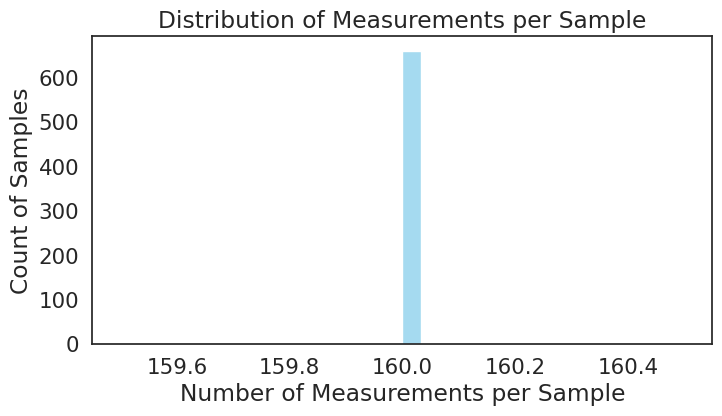

In [9]:
# Count number of measurements per sample
sample_counts = X_train_i.groupby('sample_index').size()  # Series: index=sample_index, value=count

# Plot distribution of measurement per unique sample_id
plt.figure(figsize=(8,4))
sns.histplot(sample_counts, bins=30, kde=False, color='skyblue')
plt.title("Distribution of Measurements per Sample")
plt.xlabel("Number of Measurements per Sample")
plt.ylabel("Count of Samples")
plt.show()


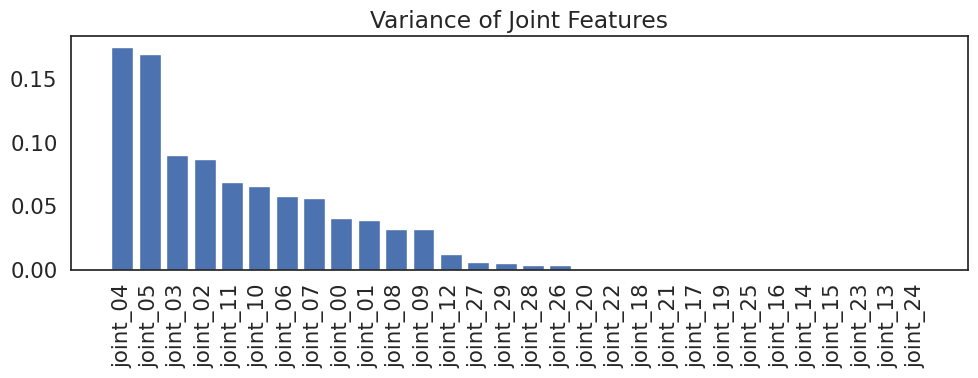

In [10]:
joint_cols = [f'joint_{i:02d}' for i in range(30)]
variances = X_train_i[joint_cols].var().sort_values(ascending=False)

plt.figure(figsize=(10,4))
plt.bar(range(len(variances)), variances)
plt.xticks(range(len(variances)), variances.index, rotation=90)
plt.title('Variance of Joint Features')
plt.tight_layout()
plt.show()

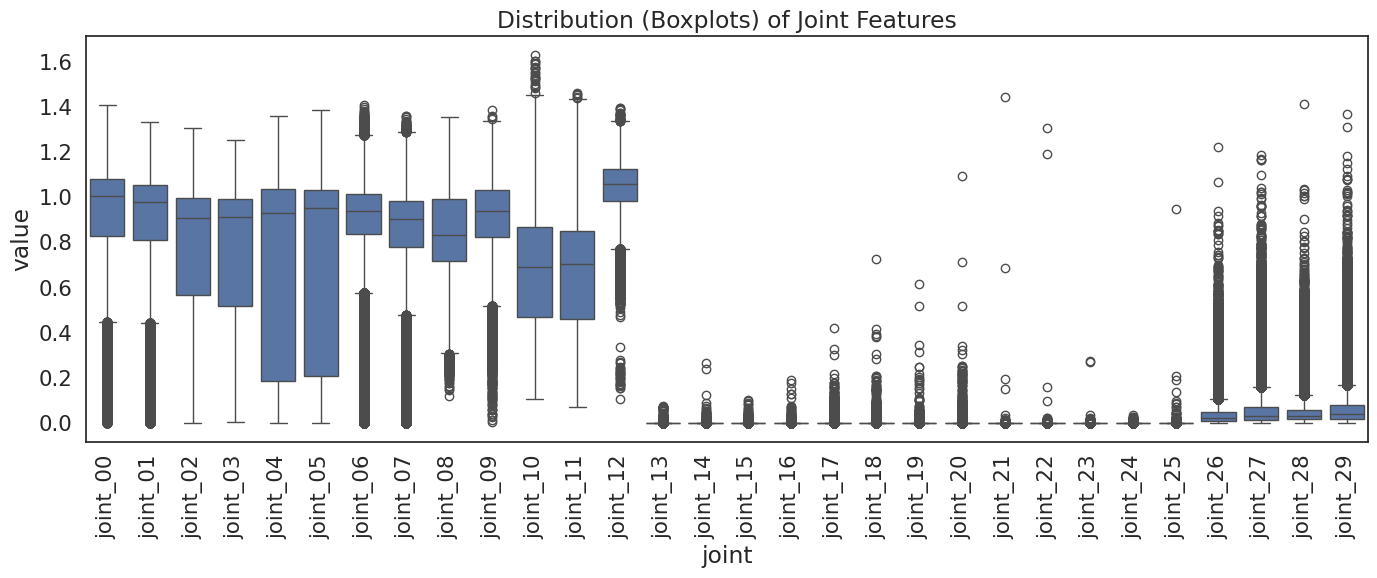

In [11]:
df_melted = X_train_i[joint_cols].melt(var_name='joint', value_name='value')
plt.figure(figsize=(14,6))
sns.boxplot(data=df_melted, x='joint', y='value')
plt.xticks(rotation=90)
plt.title('Distribution (Boxplots) of Joint Features')
plt.tight_layout()
plt.show()

In [12]:
faulted_joint_features = ['joint_30']
spikes_joint_features = []
log_joint_features = ['joint_26','joint_27','joint_28','joint_29','joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25']

In [13]:
#See which values exist in the columns that are not numbers
print(X_train_i["n_legs"].unique())
print(X_train_i["n_hands"].unique())
print(X_train_i["n_eyes"].unique())

['two' 'one+peg_leg']
['two' 'one+hook_hand']
['two' 'one+eye_patch']


## Data preprocessing

In [14]:
def apply_standard_preprocessing(df, drop_features=[], spikes_features=[], log_features=[]):
    """
    Applies standard preprocessing steps (type conversion, binary encoding,
    feature dropping) to a single DataFrame.
    """
    # --- Feature Definition ---
    # Construct column lists
    joint_cols = [f'joint_{i:02d}' for i in range(31)]
    pain_cols = [f'pain_survey_{i}' for i in range(1, 5)]
    numeric_cols = ['time'] + pain_cols + joint_cols
    binary_cols = ['n_legs', 'n_hands', 'n_eyes']

    # --- Type Conversion ---
    # Convert numeric columns to float32
    # Use .loc to avoid SettingWithCopyWarning, although here it is less of an issue
    df.loc[:, numeric_cols] = df.loc[:, numeric_cols].astype(np.float32)

    # --- Binary Encoding ---
    # Convert binary object columns to 0/1, where 'two' is 1.0
    #label_mapping = {'two': 1.0, 'one+peg_leg':0.0, 'one+hook_hand':0.0, 'one+eye_patch':0.0}
    for col in binary_cols:
        # We ensure the column exists before trying to map
      if col in df.columns:
        #df[col]= df[col].map(label_mapping)
        #df.loc[col] = df.loc[col].astype(np.float32)
        df.loc[:, col] = (df.loc[:, col] == 'two').astype(np.float32)


    # --- Feature Dropping ---
    for feature in drop_features:
      if feature in df.columns:
        df = df.drop(feature, axis=1)

    # --- Spikes to binary ---
    for col in spikes_features:
      z = np.abs(zscore(df[col]))
      df[col] = (z > 2.5).astype(np.float32)
    #df = df.drop(columns=spikes_features)

    # --- Log features ---
    alpha = 50  # increase to amplify effect on small values
    for col in log_features:
      df[col] = np.log1p(alpha*df[col])

    # --- Return Final Column List ---
    # Determine the final list of columns that will need scaling later
    scale_columns = df.columns.tolist()
    scale_columns.remove('sample_index')

    return df, scale_columns

In [15]:
train_df_cleaned, scale_columns = apply_standard_preprocessing(X_train_i.copy(), faulted_joint_features, spikes_joint_features, log_joint_features)
submission_df_cleaned, _ = apply_standard_preprocessing(X_test.copy(), faulted_joint_features, spikes_joint_features, log_joint_features)

In [16]:
train_df_cleaned.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_20,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,105760.000000,105760.000000,105760.000000,105760.000000,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,0.008892,0.000889,0.000858,0.001464,1.423442e-03,0.003978,0.880479,1.056985,1.030682,1.177056
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202051,0.197608,0.295605,0.300787,...,0.080974,0.021580,0.021813,0.018031,1.566520e-02,0.033301,0.634295,0.728045,0.613937,0.645779
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000,0.000000,0.000008,0.000000,5.315718e-07,0.000000,0.010095,0.000000,0.000000,0.000000
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,0.000000,0.000003,0.000017,0.000016,1.420893e-05,0.000036,0.401638,0.490180,0.595808,0.684056
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,0.000200,0.000042,0.000055,0.000051,4.372978e-05,0.000156,0.739497,0.950475,0.952478,1.082507
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,0.000972,0.000140,0.000154,0.000151,1.253695e-04,0.000497,1.232257,1.515686,1.370428,1.604605
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,4.021786,4.291964,4.193436,2.688667,1.037282e+00,3.878832,4.130047,4.100508,4.271121,4.241877


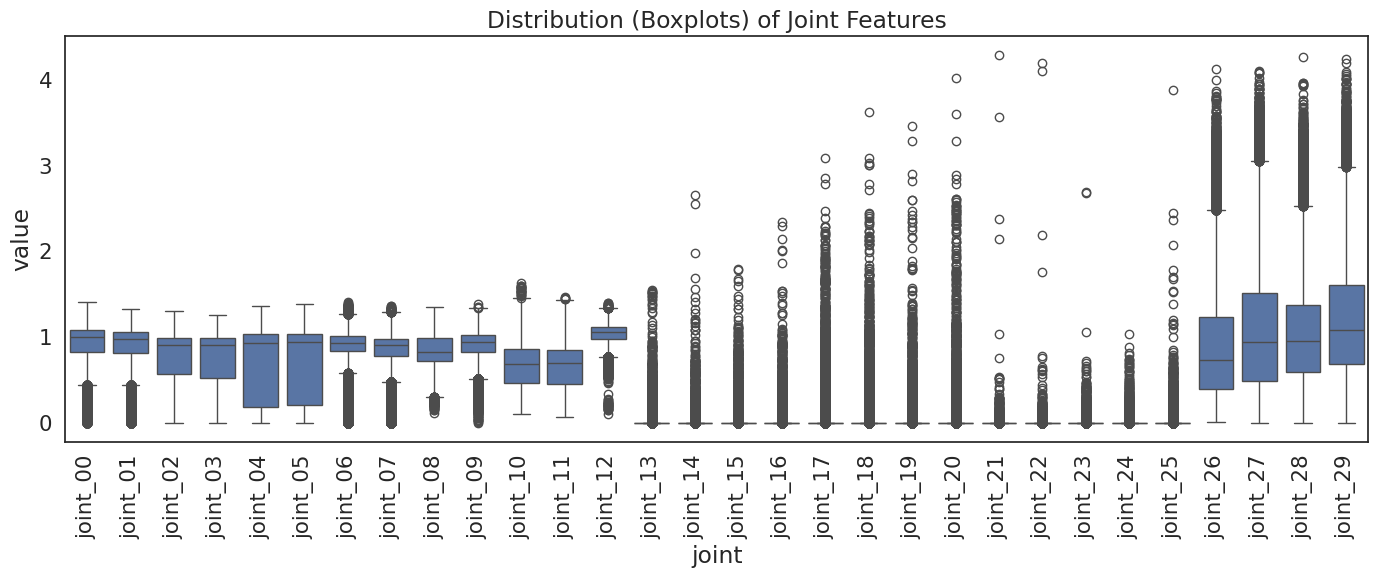

In [17]:
df_melted = train_df_cleaned[joint_cols].melt(var_name='joint', value_name='value')
plt.figure(figsize=(14,6))
sns.boxplot(data=df_melted, x='joint', y='value')
plt.xticks(rotation=90)
plt.title('Distribution (Boxplots) of Joint Features')
plt.tight_layout()
plt.show()

###Label mapping

In [18]:
label_mapping = {label: idx for idx, label in enumerate(y_train_i['label'].unique())}
labels_df_mapped = y_train_i.copy()
labels_df_mapped['label'] = y_train_i['label'].map(label_mapping).astype(np.int32)

print(label_mapping)

{'no_pain': 0, 'low_pain': 1, 'high_pain': 2}


### Split into training and validation sets

**Merge features and labels into unique dataframes**

In [19]:
df = train_df_cleaned.merge(labels_df_mapped, on='sample_index', how='left')
y_dummy = pd.DataFrame({
    'sample_index': submission_df_cleaned['sample_index'].unique(),
    'label': 0  # dummy label
})
df_submission_with_label = submission_df_cleaned.merge(y_dummy, on='sample_index', how='left')

**Actual split, with stratification by classes**

In [20]:
# First, get the sample_index and corresponding labels
samples = labels_df_mapped['sample_index']
labels = labels_df_mapped['label']

# Split train+val and test
train_val_idx, test_idx = train_test_split(
    samples,
    test_size=0.1,
    stratify=labels,
    random_state=42
)

# Split train and validation
train_idx, val_idx = train_test_split(
    train_val_idx,
    test_size=0.01,  # 0.25 * 0.8 = 0.2 overall
    stratify=labels.loc[train_val_idx],
    random_state=42
)

df_train = df[df['sample_index'].isin(train_idx)].sort_values(['sample_index','time'])
df_val   = df[df['sample_index'].isin(val_idx)].sort_values(['sample_index','time'])
df_test  = df[df['sample_index'].isin(test_idx)].sort_values(['sample_index','time'])


In [21]:
# Split whole and val for the final submission
train_whole_idx, val_whole_idx = train_test_split(
    samples,
    test_size=0.1,
    stratify=labels,
    random_state=42
)
df_whole   = df[df['sample_index'].isin(train_whole_idx)].sort_values(['sample_index','time'])
df_whole_val   = df[df['sample_index'].isin(val_whole_idx)].sort_values(['sample_index','time'])


### Normalisation

In [22]:
print(scale_columns)

['time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']


In [23]:

# Calculate the minimum and maximum values from the training data only
mins = df_train[scale_columns].min()
maxs = df_train[scale_columns].max()

# Apply normalisation to the specified columns in all datasets
for column in scale_columns:
    # Normalise the training set
    df_train[column] = (df_train[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise the validation set
    df_val[column] = (df_val[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise the test set
    df_test[column] = (df_test[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise all df
    df_whole[column] = (df_whole[column] - mins[column]) / (maxs[column] - mins[column])
    df_whole_val[column] = (df_whole_val[column] - mins[column]) / (maxs[column] - mins[column])

    # Normalise the submission test set
    df_submission_with_label[column] = (df_submission_with_label[column] - mins[column]) / (maxs[column] - mins[column])


### Build Sequences

In [24]:
# Define the window size
WINDOW_SIZE = 40

# Define the stride for overlapping windows
STRIDE = 5

In [25]:
def build_sequences(df, window=200, stride=200):
    # Sanity check
    assert window % stride == 0, "Window size must be divisible by stride"

    dataset = []
    labels = []
    sample_indexes = []

    # Get feature columns (exclude 'sample_index' and 'label')
    feature_cols = [col for col in df.columns if col not in ['sample_index', 'label']]

    # Iterate over each unique sample_index
    for sid in df['sample_index'].unique():
        # Extract all features for this sample
        temp = df[df['sample_index'] == sid][feature_cols].values.astype('float32')

        # Get the label (same for all rows with this sample_index)
        label = df.loc[df['sample_index'] == sid, 'label'].iloc[0]

        # Compute padding (if needed to make the length a multiple of window)
        padding_len = (window - len(temp) % window) % window  # avoids adding full window if already divisible
        if padding_len > 0:
            padding = np.zeros((padding_len, len(feature_cols)), dtype='float32')
            temp = np.concatenate((temp, padding))

        # Slide window through the sequence
        idx = 0
        while idx + window <= len(temp):
            dataset.append(temp[idx:idx + window])
            labels.append(label)
            idx += stride
            sample_indexes.append(sid)

    return np.array(dataset), np.array(labels, dtype=np.float32), np.array(sample_indexes)

In [26]:
# Generate sequences and labels for the training set
X_train, y_train, _ = build_sequences(df_train, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the validation set
X_val, y_val, _ = build_sequences(df_val, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the test set
X_test, y_test, _ = build_sequences(df_test, WINDOW_SIZE, STRIDE)

# Generate sequences and labels for the whole set
X_whole_df, y_whole_df, _ = build_sequences(df_whole, WINDOW_SIZE, STRIDE)
X_whole_val_df, y_whole_val_df, _ = build_sequences(df_whole_val, WINDOW_SIZE, STRIDE)


# Generate sequences, labels and indexes for the submission set
X_submission_seq, y_submission_dummy , X_submission_indexes = build_sequences(df_submission_with_label, WINDOW_SIZE, STRIDE)

# Print the shapes of the generated datasets and their labels
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape, X_submission_seq.shape, X_submission_indexes.shape, X_whole_df.shape

((14700, 40, 38),
 (14700,),
 (150, 40, 38),
 (150,),
 (1675, 40, 38),
 (1675,),
 (33100, 40, 38),
 (33100,),
 (14850, 40, 38))

In [27]:
# Define the input shape based on the training data
input_shape = X_train.shape[1:]

# Define the number of classes based on the categorical labels
num_classes = len(np.unique(y_train))

In [28]:
# Convert numpy arrays to PyTorch datasets (pairs features with labels)
train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_ds   = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_ds  = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
whole_ds  = TensorDataset(torch.from_numpy(X_whole_df), torch.from_numpy(y_whole_df))
whole_val_ds  = TensorDataset(torch.from_numpy(X_whole_val_df), torch.from_numpy(y_whole_val_df))
submission_ds  = TensorDataset(torch.from_numpy(X_submission_seq), torch.from_numpy(y_submission_dummy))

### Data loaders

In [29]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 128

In [30]:
def make_loader(ds, batch_size, shuffle, drop_last):
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Create DataLoader with performance optimizations
    return DataLoader(
        TensorDataset(ds.tensors[0], ds.tensors[1].long()), # Cast labels to long
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,  # Faster GPU transfer
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4,  # Load 4 batches ahead
    )

In [31]:
# Create data loaders with different settings for each phase
train_loader = make_loader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader   = make_loader(val_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = make_loader(test_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
full_train_loader = make_loader(whole_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
full_val_loader = make_loader(whole_val_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
submission_loader  = make_loader(submission_ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [32]:
# Get one batch from the training data loader
for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)
    print("Labels batch shape:", yb.shape)
    break # Stop after getting one batch

Features batch shape: torch.Size([128, 40, 38])
Labels batch shape: torch.Size([128])


### Recurrent summary + classifier

In [33]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [34]:
class RecurrentClassifier(nn.Module):
    """
    Generic RNN classifier (RNN, LSTM, GRU).
    Uses the last hidden state for classification.
    """
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',        # 'RNN', 'LSTM', or 'GRU'
            bidirectional=False,
            dropout_rate=0.2
            ):
        super().__init__()

        self.rnn_type = rnn_type
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional

        # Map string name to PyTorch RNN class
        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        if rnn_type not in rnn_map:
            raise ValueError("rnn_type must be 'RNN', 'LSTM', or 'GRU'")

        rnn_module = rnn_map[rnn_type]

        # Dropout is only applied between layers (if num_layers > 1)
        dropout_val = dropout_rate if num_layers > 1 else 0

        # Create the recurrent layer
        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,       # Input shape: (batch, seq_len, features)
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        # Calculate input size for the final classifier
        if self.bidirectional:
            classifier_input_size = hidden_size * 2 # Concat fwd + bwd
        else:
            classifier_input_size = hidden_size

        # Final classification layer
        self.classifier = nn.Linear(classifier_input_size, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, input_size)
        """

        # rnn_out shape: (batch_size, seq_len, hidden_size * num_directions)
        rnn_out, hidden = self.rnn(x)

        # LSTM returns (h_n, c_n), we only need h_n
        if self.rnn_type == 'LSTM':
            hidden = hidden[0]

        # hidden shape: (num_layers * num_directions, batch_size, hidden_size)

        if self.bidirectional:
            # Reshape to (num_layers, 2, batch_size, hidden_size)
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)

            # Concat last fwd (hidden[-1, 0, ...]) and bwd (hidden[-1, 1, ...])
            # Final shape: (batch_size, hidden_size * 2)
            hidden_to_classify = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            # Take the last layer's hidden state
            # Final shape: (batch_size, hidden_size)
            hidden_to_classify = hidden[-1]

        # Get logits
        logits = self.classifier(hidden_to_classify)
        return logits


# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=128,
    num_layers=2,
    num_classes=num_classes,
    dropout_rate=0.,
    rnn_type='RNN'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (RNN)                 [[-1, 40, 128], [2, -1, 128]] 54,528         
classifier (Linear)       [-1, 3]                      387            
Total params: 54,915
Trainable params: 54,915
Non-trainable params: 0
-------------------------------------------------------------------------------


## **Network and Training Hyperparameters**

In [35]:
# Training configuration
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 256       # Neurons per layer

# Regularisation
DROPOUT_RATE = 0.2         # Dropout probability
L1_LAMBDA = 0            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()

##  **Model Training**

In [36]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [37]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [38]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [39]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [40]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

### **Bidirectional Long Short-Term Memory (BiLSTM)**

<img src="https://drive.google.com/uc?export=view&id=1-W_s-cH_9wv-rmfKaa5giXzIXpdRFUpf" width="800"/>

In [41]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=True,
    rnn_type='LSTM'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "bi_lstm"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (LSTM)                [[-1, 40, 512], [4, -1, 256]] 2,183,168      
classifier (Linear)       [-1, 3]                      1,539          
Total params: 2,184,707
Trainable params: 2,184,707
Non-trainable params: 0
-------------------------------------------------------------------------------


In [42]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="bi_lstm",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.6147, F1 Score=0.7235 | Val: Loss=0.3229, F1 Score=0.7576
Epoch   2/500 | Train: Loss=0.4486, F1 Score=0.8157 | Val: Loss=0.3528, F1 Score=0.7732
Epoch   3/500 | Train: Loss=0.3612, F1 Score=0.8670 | Val: Loss=0.2663, F1 Score=0.7732
Epoch   4/500 | Train: Loss=0.3034, F1 Score=0.8881 | Val: Loss=0.3753, F1 Score=0.7576
Epoch   5/500 | Train: Loss=0.2434, F1 Score=0.9082 | Val: Loss=0.2964, F1 Score=0.7576
Epoch   6/500 | Train: Loss=0.2927, F1 Score=0.8948 | Val: Loss=0.2919, F1 Score=0.7576
Epoch   7/500 | Train: Loss=0.2244, F1 Score=0.9215 | Val: Loss=0.3193, F1 Score=0.7576
Epoch   8/500 | Train: Loss=0.1979, F1 Score=0.9297 | Val: Loss=0.1958, F1 Score=0.9749
Epoch   9/500 | Train: Loss=0.1693, F1 Score=0.9383 | Val: Loss=0.4679, F1 Score=0.7576
Epoch  10/500 | Train: Loss=0.1545, F1 Score=0.9454 | Val: Loss=0.2502, F1 Score=0.8051
Epoch  11/500 | Train: Loss=0.1400, F1 Score=0.9512 | Val: Loss=0.1710, F1 Score=0.8714
Epoch  12

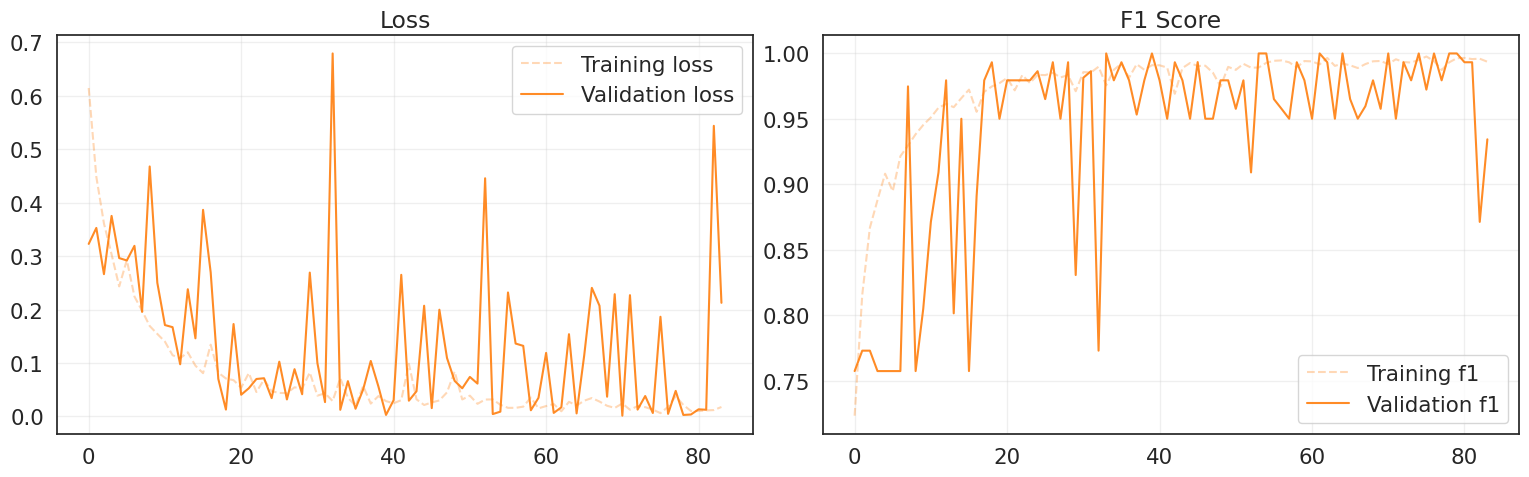

In [43]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 1.0000
Precision over the validation set: 1.0000
Recall over the validation set: 1.0000
F1 score over the validation set: 1.0000


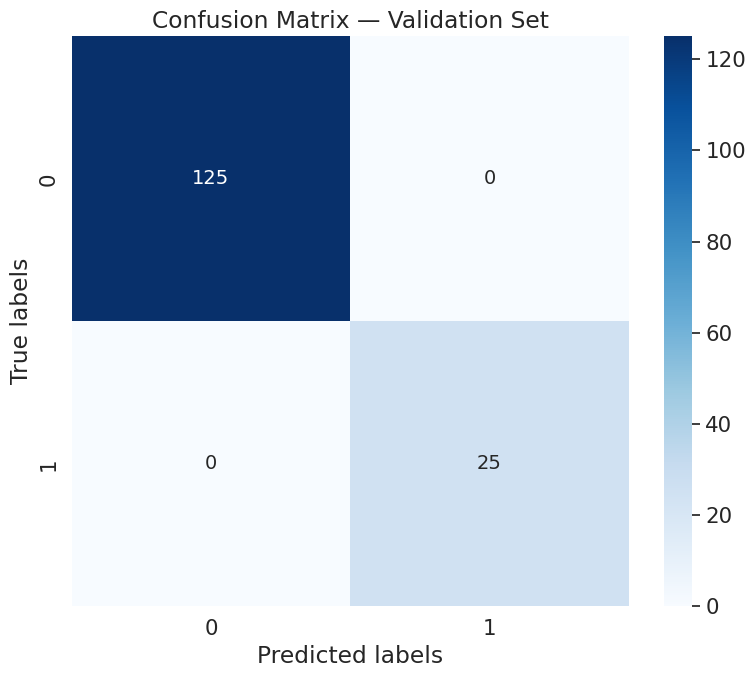

In [44]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

### **Gated Recurrent Unit (GRU)**

<img src="https://drive.google.com/uc?export=view&id=1Ux7kRpO_9zgPfxITPjAsRZEOuVcJZVgg" width="1000"/>

In [45]:
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='GRU'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "gru"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 40, 256], [2, -1, 256]] 622,080        
classifier (Linear)       [-1, 3]                      771            
Total params: 622,851
Trainable params: 622,851
Non-trainable params: 0
-------------------------------------------------------------------------------


In [46]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=1,
    experiment_name="gru",
    patience=20
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.6290, F1 Score=0.7167 | Val: Loss=0.3517, F1 Score=0.7576
Epoch   2/500 | Train: Loss=0.5044, F1 Score=0.7921 | Val: Loss=0.3520, F1 Score=0.7576
Epoch   3/500 | Train: Loss=0.3978, F1 Score=0.8505 | Val: Loss=0.4235, F1 Score=0.7576
Epoch   4/500 | Train: Loss=0.3118, F1 Score=0.8912 | Val: Loss=0.2817, F1 Score=0.7878
Epoch   5/500 | Train: Loss=0.2584, F1 Score=0.9084 | Val: Loss=0.3030, F1 Score=0.7576
Epoch   6/500 | Train: Loss=0.2151, F1 Score=0.9254 | Val: Loss=0.3450, F1 Score=0.7576
Epoch   7/500 | Train: Loss=0.1949, F1 Score=0.9305 | Val: Loss=0.2845, F1 Score=0.7576
Epoch   8/500 | Train: Loss=0.1616, F1 Score=0.9426 | Val: Loss=0.4548, F1 Score=0.7576
Epoch   9/500 | Train: Loss=0.1695, F1 Score=0.9435 | Val: Loss=0.6498, F1 Score=0.7576
Epoch  10/500 | Train: Loss=0.1170, F1 Score=0.9600 | Val: Loss=0.3074, F1 Score=0.7576
Epoch  11/500 | Train: Loss=0.1174, F1 Score=0.9609 | Val: Loss=0.3108, F1 Score=0.7576
Epoch  12

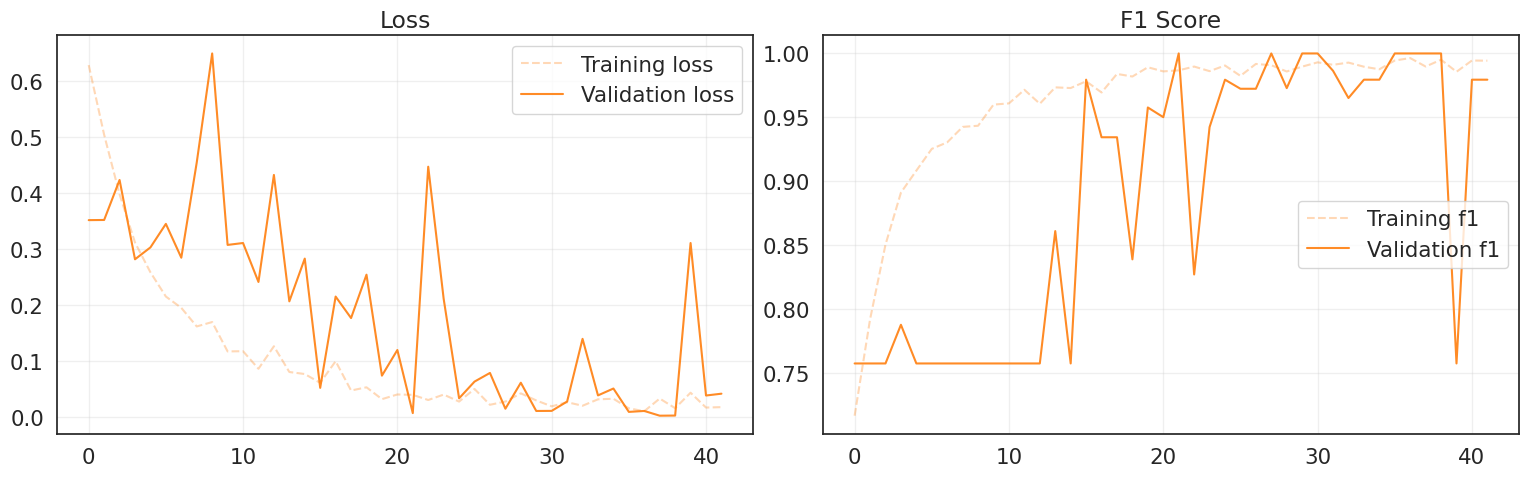

In [47]:
# @title Plot History
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 1.0000
Precision over the validation set: 1.0000
Recall over the validation set: 1.0000
F1 score over the validation set: 1.0000


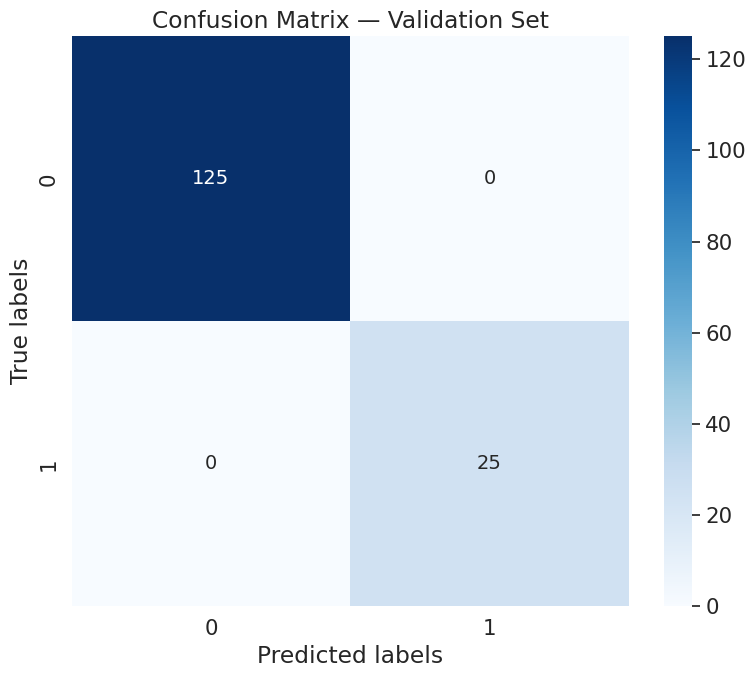

In [48]:
# @title Plot Confusion matrix
  # Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

## Save best model and create submission

In [49]:
# Define path
save_dir = "models"
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "best_rnn_model.pth")

# Save the best model’s state dict
torch.save(best_model.state_dict(), save_path)

print(f"✅ Model weights saved to {save_path}")

✅ Model weights saved to models/best_rnn_model.pth


In [50]:
preds = []

# Inference
with torch.no_grad():
    for xb, _ in submission_loader:  # assuming labels are not needed
        xb = xb.to(device)

        # Forward pass
        logits = best_model(xb)
        pred = logits.argmax(dim=1).cpu().numpy()

        # Store batch predictions
        preds.append(pred)

# Combine all batches
preds = np.concatenate(preds)

# Map integer predictions to label names
inv_label_mapping = {v: k for k, v in label_mapping.items()}
submission_labels = np.array([inv_label_mapping[p] for p in preds])

# Create DataFrame with sequence-level predictions
output = pd.DataFrame({
    'sample_index': X_submission_indexes,  # one per sequence/window
    'label': submission_labels
})

# Reduce to one label per sample_index by majority vote
final_output = output.groupby('sample_index')['label'] \
                     .agg(lambda x: x.value_counts().idxmax()) \
                     .reset_index()

print(final_output.shape)  # should be (1324, 2) if 1324 unique samples
final_output.head(500)

(1324, 2)


,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,no_pain
3,3,no_pain
4,4,no_pain
...,...,...
495,495,no_pain
496,496,no_pain
497,497,no_pain
498,498,no_pain


In [51]:
final_output.to_csv('submission.csv', index=False)